In [1]:
!pwd

/mnt/d/github/machine-learning/DCGAN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:08<00:00, 1104167.97it/s]


Extracting ./coding/learning/lrdata/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./coding/learning/lrdata/MNIST/MNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 174288.19it/s]


Extracting ./coding/learning/lrdata/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./coding/learning/lrdata/MNIST/MNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:02<00:00, 605755.52it/s]


Extracting ./coding/learning/lrdata/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./coding/learning/lrdata/MNIST/MNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 8742785.12it/s]


Extracting ./coding/learning/lrdata/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./coding/learning/lrdata/MNIST/MNIST/raw

tensor([7, 8, 6, 0, 3])


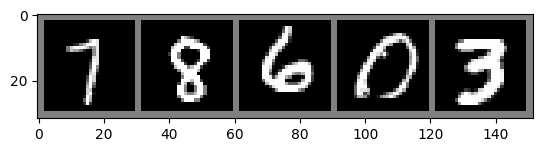

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from torch.autograd import Variable
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt

data_tf = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])]
)

train_dataset = datasets.MNIST(root='./coding/learning/lrdata/MNIST',train=True,transform=data_tf,download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=5,
                                           shuffle=True)
# 实现单张图片可视化
images, labels = next(iter(train_loader))
img = torchvision.utils.make_grid(images)

img = img.numpy().transpose(1, 2, 0)
std = [0.5, 0.5, 0.5]
mean = [0.5, 0.5, 0.5]
img = img * std + mean
print(labels)
plt.imshow(img)
plt.show()